In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator #
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

from keras import layers
from keras import models
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Garbage.1

/content/drive/MyDrive/Garbage.1


In [4]:
# Define directories for train, test and validation data
train_dir = "/content/drive/MyDrive/Garbage.1/train"
test_dir = "/content/drive/MyDrive/Garbage.1/test"
validation_dir = "/content/drive/MyDrive/Garbage.1/validation"

# Define batch size and image size
batch_size = 64
image_size = 128

In [5]:
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

# list containing all the filenames in the dataset
filenames_list = []

# Iterate through categories and filenames, adding them to the respective lists
for category in os.listdir(train_dir):
    for filename in os.listdir(os.path.join(train_dir, category)):
        filenames_list.append(os.path.join(category, filename))
        categories_list.append(category)

# Create a DataFrame with filenames and categories
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  2741


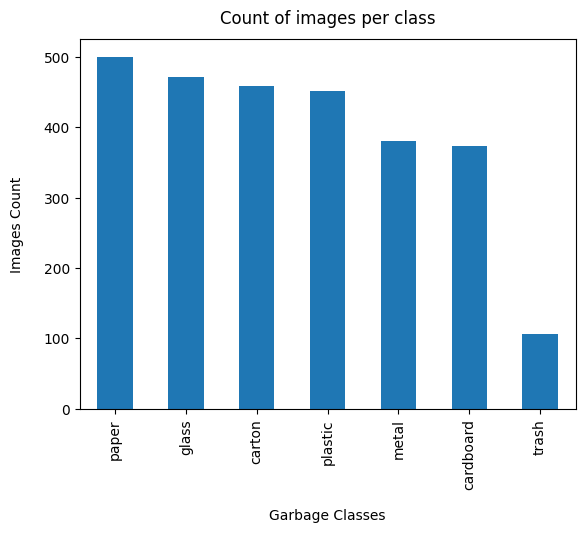

In [6]:
# Createting a barplot to visualize the distribution of images
df_visualization = df.copy()

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# We can see here that this data is imbalanced

In [7]:
# Initialize the ImageDataGenerators for the training and validation sets
# Upsampling train data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        shuffle=True,
        # All images will be resized to image_size set earlier
        target_size=(image_size, image_size),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       shuffle=False,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

Found 2741 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


In [8]:
# Adding class weights to balance the data
# Get class labels and indices from the generators
class_labels = list(train_generator.class_indices.keys())
class_indices = np.array(list(train_generator.class_indices.values()))

# Calculate class weights using scikit-learn's compute_class_weight function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weights = dict(enumerate(class_weights))

# Convert class_weights to a dictionary to pass it to the model.fit() method
class_weights = {i: class_weights[i] for i in range(len(class_labels))}

In [9]:
# Labels and indices
print(class_labels)
print(class_indices)

['cardboard', 'carton', 'glass', 'metal', 'paper', 'plastic', 'trash']
[0 1 2 3 4 5 6]


In [10]:
# Looking at the weight distribution
class_weights

{0: 1.0497893527384143,
 1: 0.85495945102932,
 2: 0.8313618441006976,
 3: 1.030451127819549,
 4: 0.7831428571428571,
 5: 0.8663084702907712,
 6: 3.65954606141522}

In [ ]:
# Baseline model
# Defining model architecture
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))   # Add dropout with rate of 0.5
model.add(Dense(7, activation='softmax'))

# This was the combination of layers and regularizations that gave me the best results

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
# Print model summary
model.summary()

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model on the training set and validate on the validation set
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=30, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator), 
                    verbose=2,
                    callbacks=[early_stop],
                    class_weight=class_weights)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 64)       

In [ ]:
# Define test data generator and get test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle=False, 
                                                  target_size=(image_size, image_size), 
                                                  batch_size=batch_size, 
                                                  class_mode='categorical')

# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = model.evaluate(test_x, test_y)

# After trying all diferent kinds of combinations without making any relevant improvement, I decided to use transfer learning to see if I could get better results

Found 105 images belonging to 7 classes.
2/2 [==============================] - 1s 514ms/step - loss: 1.3147 - acc: 0.3750


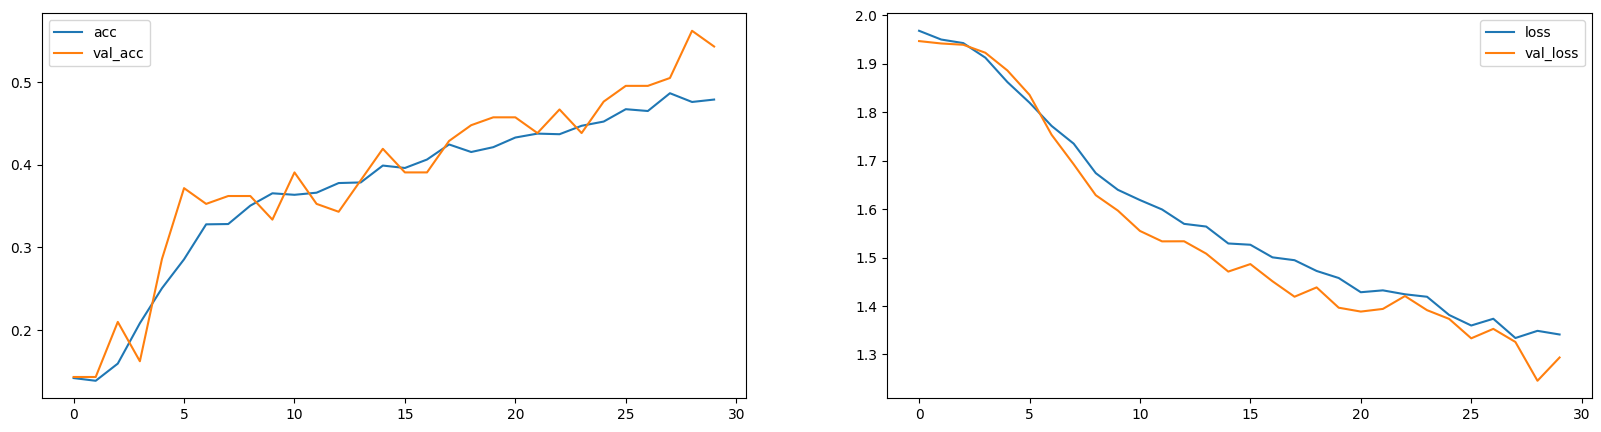

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Get the predicted probabilities for the validation set
pred_probs = model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

2/2 [==============================] - 2s 395ms/step


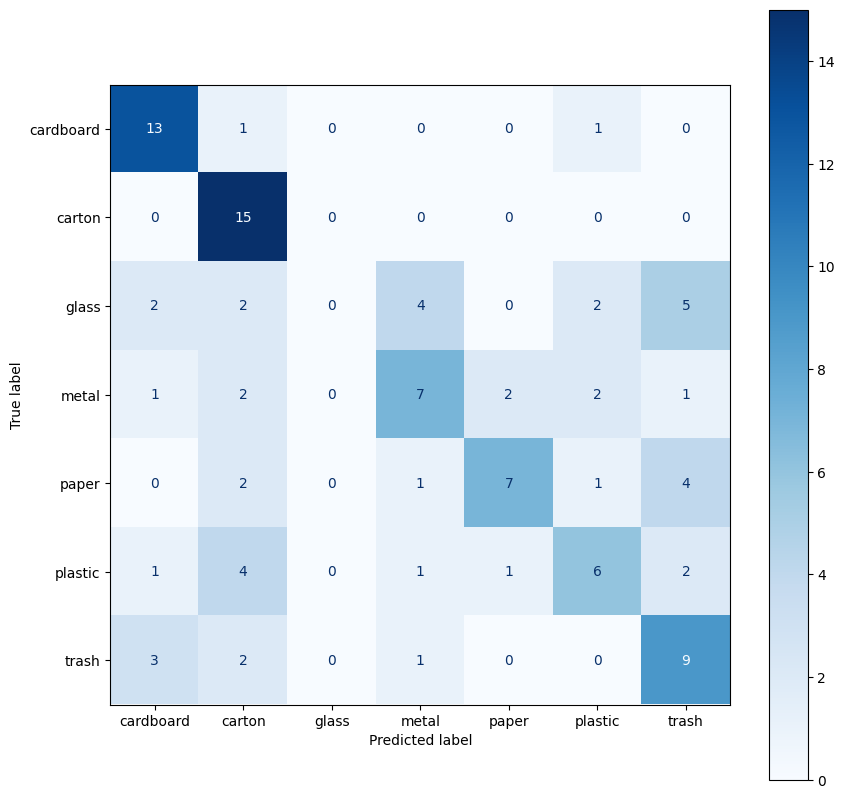

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

   cardboard       0.65      0.87      0.74        15
      carton       0.54      1.00      0.70        15
       glass       0.00      0.00      0.00        15
       metal       0.50      0.47      0.48        15
       paper       0.70      0.47      0.56        15
     plastic       0.50      0.40      0.44        15
       trash       0.43      0.60      0.50        15

    accuracy                           0.54       105
   macro avg       0.47      0.54      0.49       105
weighted avg       0.47      0.54      0.49       105

